Fashion Forward is a new AI-based e-commerce clothing retailer. They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall
import matplotlib.pyplot as plt

In [5]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:46<00:00, 565kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 154kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.67MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 2.50MB/s]


In [23]:
# Dataset Preparation
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array or tensor): Input data (e.g., images).
            labels (numpy array or tensor): Corresponding labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [24]:
# Model Definition
class EnhancedClothingClassifierCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedClothingClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.flattened_size = (input_size // 8) * (input_size // 8) * 128  # Adjust for pooling layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [25]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [26]:
# Evaluation
def evaluate_model(model, test_loader, num_classes, device):
    model.to(device)
    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)(torch.tensor(predictions), torch.tensor(true_labels)).item()
    precision = Precision(task="multiclass", average=None, num_classes=num_classes)(torch.tensor(predictions), torch.tensor(true_labels)).tolist()
    recall = Recall(task="multiclass", average=None, num_classes=num_classes)(torch.tensor(predictions), torch.tensor(true_labels)).tolist()

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    return predictions, accuracy, precision, recall

In [27]:
# Plotting Function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.show()

Epoch 1/10, Train Loss: 2.7309, Train Acc: 0.1000, Val Loss: 2.3039, Val Acc: 0.1000
Epoch 2/10, Train Loss: 2.2919, Train Acc: 0.1375, Val Loss: 2.2913, Val Acc: 0.1300
Epoch 3/10, Train Loss: 2.2900, Train Acc: 0.1150, Val Loss: 2.3109, Val Acc: 0.1300
Epoch 4/10, Train Loss: 2.2698, Train Acc: 0.1537, Val Loss: 2.3236, Val Acc: 0.1200
Epoch 5/10, Train Loss: 2.2524, Train Acc: 0.1600, Val Loss: 2.3055, Val Acc: 0.1000
Epoch 6/10, Train Loss: 2.2326, Train Acc: 0.1762, Val Loss: 2.3183, Val Acc: 0.0900
Epoch 7/10, Train Loss: 2.1864, Train Acc: 0.1775, Val Loss: 2.3272, Val Acc: 0.0900
Epoch 8/10, Train Loss: 2.1267, Train Acc: 0.2300, Val Loss: 2.3396, Val Acc: 0.1400
Epoch 9/10, Train Loss: 2.0535, Train Acc: 0.2387, Val Loss: 2.3460, Val Acc: 0.0900
Epoch 10/10, Train Loss: 1.9773, Train Acc: 0.2550, Val Loss: 2.3207, Val Acc: 0.1000


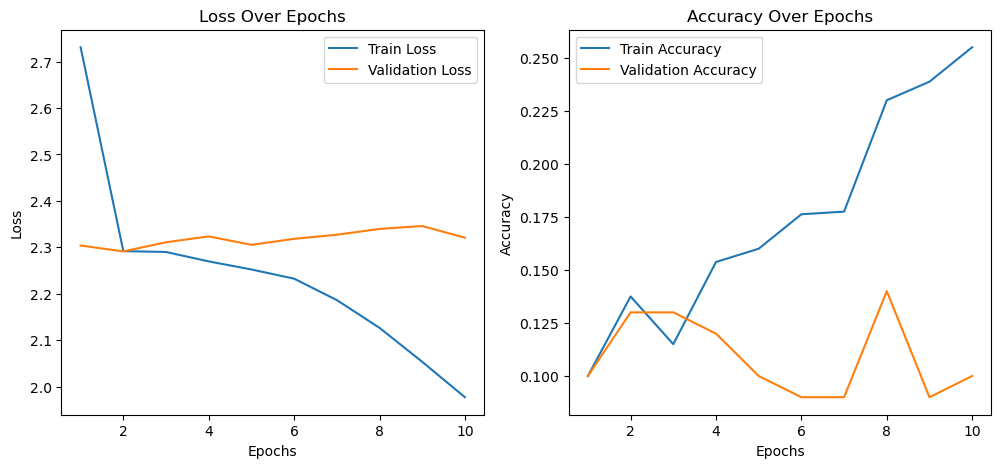

Accuracy: 0.1500
Precision: [0.0, 0.1875, 0.0, 0.1875, 0.1607142835855484, 0.0, 0.0, 0.0, 0.0, 0.0]
Recall: [0.0, 0.3333333432674408, 0.0, 0.27272728085517883, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0]


In [28]:
# Main Script
if __name__ == "__main__":
    # Hyperparameters
    input_size = 32  # Assuming 32x32 images
    num_classes = 10  # Adjust based on your dataset
    batch_size = 64
    learning_rate = 0.001
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data Augmentation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create dummy dataset (replace with your actual dataset)
    class DummyDataset(Dataset):
        def __init__(self, num_samples, input_size, num_classes):
            self.data = torch.randn(num_samples, 3, input_size, input_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.labels[idx]

    train_dataset = DummyDataset(800, input_size, num_classes)
    val_dataset = DummyDataset(100, input_size, num_classes)
    test_dataset = DummyDataset(100, input_size, num_classes)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = EnhancedClothingClassifierCNN(input_size=input_size, num_classes=num_classes)
    class_weights = torch.tensor([1.0] * num_classes).to(device)  # Adjust weights for class imbalance if needed
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, epochs
    )

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    # Evaluate the model
    predictions, accuracy, precision, recall = evaluate_model(model, test_loader, num_classes, device)